https://www.dominodatalab.com/blog/getting-started-with-k-means-clustering-in-python

In [ ]:
from sklearn.cluster import KMeans
from sklearn import datasets
from sklearn.utils import shuffle
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn import preprocessing
# import some data to play with
data = pd.read_csv('kmeans.csv', header='infer')
le = preprocessing.LabelEncoder()
le.fit(data['class'])
data['class']=le.transform(data['class'])

#data1 = data.drop(columns=['class', "mfcc_2_mean", "mfcc_3_mean",  "mfcc_4_mean", "mfcc_5_mean", "mfcc_6_mean", "mfcc_7_mean", "mfcc_8_mean","mfcc_9_mean","mfcc_10_mean","mfcc_11_mean","mfcc_12_mean",	"mfcc_13_mean"])
data1 = data.sample(frac=0.05, replace=True, random_state=1)
data = data.sample(frac=0.05, replace=True, random_state=1)

X = data1
y = data['class']
#names = iris.feature_names

In [ ]:

#Put data onto the same standard scale
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import StandardScaler

scaler=StandardScaler()
scaler.fit(data1)
data1=scaler.fit_transform(data1)
data1

In [ ]:
plt.scatter(data1[1:,0],data1[1:,1:])
plt.xlabel('ZCR_MEAN')
plt.ylabel('MFCC_1_MEAN')
plt.show()

In [ ]:
kmeans = KMeans(n_clusters=4, random_state=42) 
kmeans.fit(X)
y_kmeans = kmeans.predict(X)

In [ ]:
kmeans.labels_

In [ ]:
from sklearn.metrics import confusion_matrix
conf_matrix=confusion_matrix(y, kmeans.labels_) 

fig, ax = plt.subplots(figsize=(7.5, 7.5))
ax.matshow(conf_matrix, cmap=plt.cm.Blues, alpha=0.3)
for i in range(conf_matrix.shape[0]):
    for j in range(conf_matrix.shape[1]):
        ax.text(x=j, y=i,s=conf_matrix[i, j], va='center', 
                ha='center', size='xx-large')
 
plt.xlabel('Predictions', fontsize=18)
plt.ylabel('Actuals', fontsize=18)
plt.title('Confusion Matrix', fontsize=18)
plt.show()

In [ ]:
kmeans.cluster_centers_


In [ ]:
plt.scatter(X.iloc[:, 0], X.iloc[:, 1], c=y_kmeans, s=50, cmap='viridis')

centers = kmeans.cluster_centers_
plt.scatter(centers[:, 0], centers[:, 1], c='black', s=200, alpha=0.5);

https://notebook.community/ml4a/ml4a-guides/notebooks/audio-tsne

In [3]:
%pip install librosa==0.7.0


Note: you may need to restart the kernel to use updated packages.


In [6]:
%matplotlib inline
from matplotlib import pyplot as plt
import matplotlib.cm as cm
import fnmatch
import os
import librosa
import numpy as np
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE
import json
from sklearn.cluster import KMeans
import pandas as pd

scan some directory of audio files and collect all their paths into a single list

In [2]:
path = 'D:\\PhD-data\\Tarcutta - Processed'

files = []
for root, dirnames, filenames in os.walk(path):
    for filename in fnmatch.filter(filenames, '*.wav'):
        files.append(os.path.join(root, filename))

print("found %d .wav files in %s"%(len(files),path))

found 7079 .wav files in D:\PhD-data\Tarcutta - Processed


In [3]:
# import librosa
# import numpy as np
# import pandas as pd

# # Create an empty list to store the extracted features
# features = []

# # Loop through all file paths
# for file_path in files:
#     # Load the audio file
#     y, sr = librosa.load(file_path)
    
#     # Extract the MFCC features and their first and second order derivatives
#     mfcc = librosa.feature.mfcc(y=y, sr=sr, n_mfcc=13, lifter=0, n_fft=2048, hop_length=512)
#     mfcc_delta = librosa.feature.delta(mfcc)
#     mfcc_delta2 = librosa.feature.delta(mfcc, order=2)
    
#     # Concatenate the features and their derivatives into a single array
#     features_row = np.concatenate((mfcc, mfcc_delta, mfcc_delta2))
    
#     # Add the filename as the final column
#     file_name = file_path.split('/')[-1]  # Extract the filename from the file path
#     features_row = np.append(features_row, file_name)
    
#     # Add the row of features to the list of features
#     features.append(features_row)

# # Convert the list of features to a DataFrame and save as a .csv file
# df = pd.DataFrame(features)
# df.to_csv('output.csv', header=False, index=False)


function which extracts a feature vector from an audio file

The feature extraction will calculate the first 13 mel-frequency cepstral coefficients of the audio file, as well as their first- and second-order derivatives, and concatenate them into a single 39-element feature vector. The feature vector is also standardized so that each feature has equal variance.

In [3]:
def get_features(y, sr):
    y = y[0:sr]  # analyze just first second
    S = librosa.feature.melspectrogram(y, sr=sr, n_mels=128)
    log_S = librosa.amplitude_to_db(S, ref=np.max)
    mfcc = librosa.feature.mfcc(S=log_S, n_mfcc=13)
    delta_mfcc = librosa.feature.delta(mfcc, mode='nearest')
    delta2_mfcc = librosa.feature.delta(mfcc, order=2, mode='nearest')
    feature_vector = np.concatenate((np.mean(mfcc,1), np.mean(delta_mfcc,1), np.mean(delta2_mfcc,1)))
    feature_vector = (feature_vector-np.mean(feature_vector)) / np.std(feature_vector)
    return feature_vector

Now we will iterate through all the files, and get their feature vectors, placing them into a new list feature_vectors. We also make a new array sound_paths to index the feature vectors to the correct paths

In [4]:
import librosa
feature_vectors = []
sound_paths = []
for i,f in enumerate(files):
    if i % 100 == 0:
        print("get %d of %d = %s"%(i+1, len(files), f))
    y, sr = librosa.load(f)
    if len(y) < 2:
        print("error loading %s" % f)
        continue
    feat = get_features(y, sr)
    feature_vectors.append(feat)
    sound_paths.append(f)
        
print("calculated %d feature vectors"%len(feature_vectors))

get 1 of 7079 = D:\PhD-data\Tarcutta - Processed\anthrophony\audio_segment_DryB0_1.wav
get 101 of 7079 = D:\PhD-data\Tarcutta - Processed\anthrophony\audio_segment_DryB109_6.wav
get 201 of 7079 = D:\PhD-data\Tarcutta - Processed\anthrophony\audio_segment_DryB116_2.wav
get 301 of 7079 = D:\PhD-data\Tarcutta - Processed\anthrophony\audio_segment_DryB15_11.wav
get 401 of 7079 = D:\PhD-data\Tarcutta - Processed\anthrophony\audio_segment_DryB22_8.wav
get 501 of 7079 = D:\PhD-data\Tarcutta - Processed\anthrophony\audio_segment_DryB2_4.wav
get 601 of 7079 = D:\PhD-data\Tarcutta - Processed\anthrophony\audio_segment_DryB39_12.wav
get 701 of 7079 = D:\PhD-data\Tarcutta - Processed\anthrophony\audio_segment_DryB45_9.wav
get 801 of 7079 = D:\PhD-data\Tarcutta - Processed\anthrophony\audio_segment_DryB52_5.wav
get 901 of 7079 = D:\PhD-data\Tarcutta - Processed\anthrophony\audio_segment_DryB5_13.wav
get 1001 of 7079 = D:\PhD-data\Tarcutta - Processed\anthrophony\audio_segment_DryB67_1.wav
get 1101 

In [8]:
df = pd.DataFrame(feature_vectors)
df.to_csv("39-features-tarcutta-sound.csv")

In [9]:
from sklearn import preprocessing
import pandas as pd

x = feature_vectors
min_max_scaler = preprocessing.MinMaxScaler()
x_scaled = min_max_scaler.fit_transform(x)
feature_vectors = pd.DataFrame(x_scaled)
print(feature_vectors)
df = pd.DataFrame(feature_vectors)
df.to_csv('39-features-tarcutta-sound.csv', header=False, index=False)

            0         1         2         3         4         5         6   \
0     0.646336  0.844683  0.543980  0.373283  0.611460  0.331930  0.753110   
1     0.568359  0.783085  0.513727  0.440833  0.569069  0.363196  0.811650   
2     0.605534  0.794485  0.474618  0.367434  0.576273  0.530048  0.877311   
3     0.342857  0.605600  0.606426  0.531328  0.506826  0.314581  0.699506   
4     0.328964  0.587936  0.569250  0.490481  0.520936  0.364828  0.806001   
...        ...       ...       ...       ...       ...       ...       ...   
7074  0.228802  0.434234  0.774553  0.558380  0.624329  0.500528  0.521208   
7075  0.201230  0.409413  0.753505  0.527024  0.614602  0.541449  0.541171   
7076  0.149391  0.347022  0.757374  0.497583  0.651070  0.470718  0.591280   
7077  0.162384  0.352241  0.771799  0.502642  0.674615  0.479345  0.619002   
7078  0.149960  0.347814  0.767191  0.477584  0.669370  0.436909  0.609907   

            7         8         9   ...        29        30    

Now we can run t-SNE over the feature vectors to get a 2-dimensional embedding of our audio files. We use scikit-learn's TSNE function, and additionally normalize the results so that they are between 0 and 1.

In [10]:
import pandas as pd
feature_vectors = pd.read_csv("39-features-tarcutta-sound.csv")
feature_vectors

,0,1,2,3,4,5,6,7,8,9,...,31,32,33,34,35,36,37,38,path,class
0,0.646336,0.844683,0.543980,0.373283,0.611460,0.331930,0.753110,0.609953,0.566535,0.169309,...,0.261369,0.253211,0.247416,0.251408,0.242194,0.245324,0.249546,0.243950,D:\PhD-data\Tarcutta - Processed\anthrophony\a...,anthrophony
1,0.568359,0.783085,0.513727,0.440833,0.569069,0.363196,0.811650,0.477184,0.526423,0.287786,...,0.351950,0.353321,0.343293,0.341018,0.341530,0.343564,0.342811,0.341488,D:\PhD-data\Tarcutta - Processed\anthrophony\a...,anthrophony
2,0.605534,0.794485,0.474618,0.367434,0.576273,0.530048,0.877311,0.445860,0.517366,0.434282,...,0.291669,0.295233,0.297816,0.292029,0.288880,0.293009,0.295303,0.288725,D:\PhD-data\Tarcutta - Processed\anthrophony\a...,anthrophony
3,0.342857,0.605600,0.606426,0.531328,0.506826,0.314581,0.699506,0.385028,0.401659,0.428337,...,0.438030,0.430004,0.432435,0.428890,0.425336,0.432606,0.438634,0.437383,D:\PhD-data\Tarcutta - Processed\anthrophony\a...,anthrophony
4,0.328964,0.587936,0.569250,0.490481,0.520936,0.364828,0.806001,0.428655,0.428980,0.347441,...,0.504833,0.504263,0.504545,0.504352,0.502340,0.510355,0.514403,0.506405,D:\PhD-data\Tarcutta - Processed\anthrophony\a...,anthrophony
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7074,0.228802,0.434234,0.774553,0.558380,0.624329,0.500528,0.521208,0.541478,0.577106,0.490285,...,0.093653,0.095979,0.094496,0.092827,0.083902,0.092052,0.096582,0.087762,D:\PhD-data\Tarcutta - Processed\other\audio_s...,other
7075,0.201230,0.409413,0.753505,0.527024,0.614602,0.541449,0.541171,0.561533,0.576810,0.539425,...,0.114818,0.111903,0.110325,0.108651,0.106088,0.113555,0.110863,0.112218,D:\PhD-data\Tarcutta - Processed\other\audio_s...,other
7076,0.149391,0.347022,0.757374,0.497583,0.651070,0.470718,0.591280,0.523762,0.660586,0.490826,...,0.129756,0.135499,0.132764,0.135778,0.133087,0.130080,0.134311,0.131803,D:\PhD-data\Tarcutta - Processed\other\audio_s...,other
7077,0.162384,0.352241,0.771799,0.502642,0.674615,0.479345,0.619002,0.523655,0.685822,0.487827,...,0.102426,0.101197,0.099734,0.102849,0.101283,0.103253,0.107666,0.095977,D:\PhD-data\Tarcutta - Processed\other\audio_s...,other


In [11]:
import pandas as pd

# Drop rows containing missing values
feature_vectors = feature_vectors.dropna()
#feature_vectors.to_csv('39-features-esc50-cleaned.csv', index=False)
feature_vectors = feature_vectors.drop(columns=["class"])
feature_vectors = feature_vectors.drop(columns=["path"])
feature_vectors = feature_vectors.iloc[:, 0:13]
feature_vectors


,0,1,2,3,4,5,6,7,8,9,10,11,12
0,0.646336,0.844683,0.543980,0.373283,0.611460,0.331930,0.753110,0.609953,0.566535,0.169309,0.444047,0.238773,0.299172
1,0.568359,0.783085,0.513727,0.440833,0.569069,0.363196,0.811650,0.477184,0.526423,0.287786,0.433050,0.150782,0.218110
2,0.605534,0.794485,0.474618,0.367434,0.576273,0.530048,0.877311,0.445860,0.517366,0.434282,0.401526,0.096011,0.338440
3,0.342857,0.605600,0.606426,0.531328,0.506826,0.314581,0.699506,0.385028,0.401659,0.428337,0.563285,0.197152,0.368503
4,0.328964,0.587936,0.569250,0.490481,0.520936,0.364828,0.806001,0.428655,0.428980,0.347441,0.439233,0.134062,0.316350
...,...,...,...,...,...,...,...,...,...,...,...,...,...
7074,0.228802,0.434234,0.774553,0.558380,0.624329,0.500528,0.521208,0.541478,0.577106,0.490285,0.581139,0.620883,0.475996
7075,0.201230,0.409413,0.753505,0.527024,0.614602,0.541449,0.541171,0.561533,0.576810,0.539425,0.585985,0.618801,0.492378
7076,0.149391,0.347022,0.757374,0.497583,0.651070,0.470718,0.591280,0.523762,0.660586,0.490826,0.655069,0.630417,0.583965
7077,0.162384,0.352241,0.771799,0.502642,0.674615,0.479345,0.619002,0.523655,0.685822,0.487827,0.664599,0.578734,0.536499


In [12]:
model = TSNE(n_components=2, learning_rate=150, perplexity=50, verbose=2, angle=0.1).fit_transform(feature_vectors)


[t-SNE] Computing 151 nearest neighbors...
[t-SNE] Indexed 7079 samples in 0.011s...
[t-SNE] Computed neighbors for 7079 samples in 0.338s...
[t-SNE] Computed conditional probabilities for sample 1000 / 7079
[t-SNE] Computed conditional probabilities for sample 2000 / 7079
[t-SNE] Computed conditional probabilities for sample 3000 / 7079
[t-SNE] Computed conditional probabilities for sample 4000 / 7079
[t-SNE] Computed conditional probabilities for sample 5000 / 7079
[t-SNE] Computed conditional probabilities for sample 6000 / 7079
[t-SNE] Computed conditional probabilities for sample 7000 / 7079
[t-SNE] Computed conditional probabilities for sample 7079 / 7079
[t-SNE] Mean sigma: 0.061147
[t-SNE] Computed conditional probabilities in 0.160s
[t-SNE] Iteration 50: error = 73.3180313, gradient norm = 0.0228191 (50 iterations in 1.008s)
[t-SNE] Iteration 100: error = 68.4491959, gradient norm = 0.0069951 (50 iterations in 0.788s)
[t-SNE] Iteration 150: error = 67.3223038, gradient norm = 

Let's plot our t-SNE points. We can use matplotlib to quickly scatter them and see their distribution.

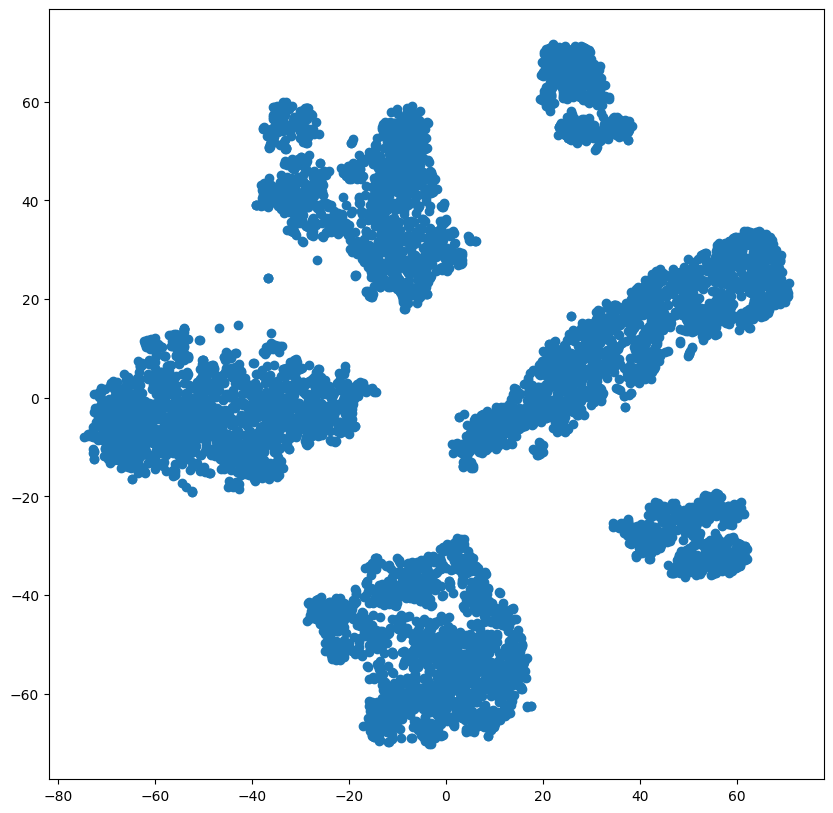

In [13]:
x_axis=model[:,0]
y_axis=model[:,1]

plt.figure(figsize = (10,10))
plt.scatter(x_axis, y_axis)
plt.show()

We see our t-SNE plot of our audio files, but it's not particularly interesting! Since we are dealing with audio files, there's no easy way to compare neighboring audio samples to each other. We can use some other, more interactive environment to view the results of the t-SNE. One way we can do this is by saving the results to a JSON file which stores the filepaths and t-SNE assignments of all the audio files. We can then load this JSON file in another environment.

In any case, to save the t-SNE to a JSON file, we first normalize the coordinates to between 0 and 1 and save them, along with the full filepaths.

In [ ]:
from pyAudioProcessing import utils


tsne_path = "example-audio-tSNE.json"

x_norm = (x_axis - np.min(x_axis)) / (np.max(x_axis) - np.min(x_axis))
y_norm = (y_axis - np.min(y_axis)) / (np.max(y_axis) - np.min(y_axis))

data = [{"path":os.path.abspath(f), "point":[x, y]} for f, x, y in zip(sound_paths, x_norm, y_norm)]
# with open(tsne_path, 'w') as outfile:
utils.write_to_json(tsne_path, str(data))
    # json.dump(data, outfile, cls=)

print("saved %s to disk!" % tsne_path)

In [57]:
km = KMeans(n_clusters=4, init='k-means++', random_state=42)
y_km = km.fit_predict(model)
labels = km.labels_

c:\Users\Thomas\conda\envs\env-02\lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


In [58]:
model[y_km == 0, 0]

array([-44.84792 , -58.601097, -50.819035, -42.08335 , -53.279114,
       -52.758522, -44.43404 , -55.755817, -57.016132, -56.762077,
       -57.701855, -51.35206 , -38.095676, -59.992195, -45.712597,
       -40.362732, -59.929817, -60.852524, -60.91771 , -62.189922,
       -60.919163, -53.67558 , -53.017864, -52.865864, -62.211143,
       -61.46019 , -61.417736, -56.775906, -61.50772 , -61.69233 ,
       -53.122524, -61.841087, -59.46803 , -49.625053, -41.624233,
       -62.642975, -51.11213 , -44.234974, -58.491364, -41.819695,
       -58.89615 , -46.55421 , -63.79589 , -60.78087 , -42.308167,
       -57.230804, -58.0696  , -38.594376, -40.487335, -60.91607 ,
       -39.563118, -62.8533  , -39.065548, -57.8137  , -38.444164,
       -54.04383 , -39.50765 , -56.063465, -56.07274 , -56.76712 ,
       -57.174995, -58.126827, -48.16461 , -55.434227, -56.595997,
       -57.54685 , -59.68229 , -61.542492, -56.247147, -56.59377 ,
       -62.494804, -46.573956, -61.290264, -64.35793 , -64.104

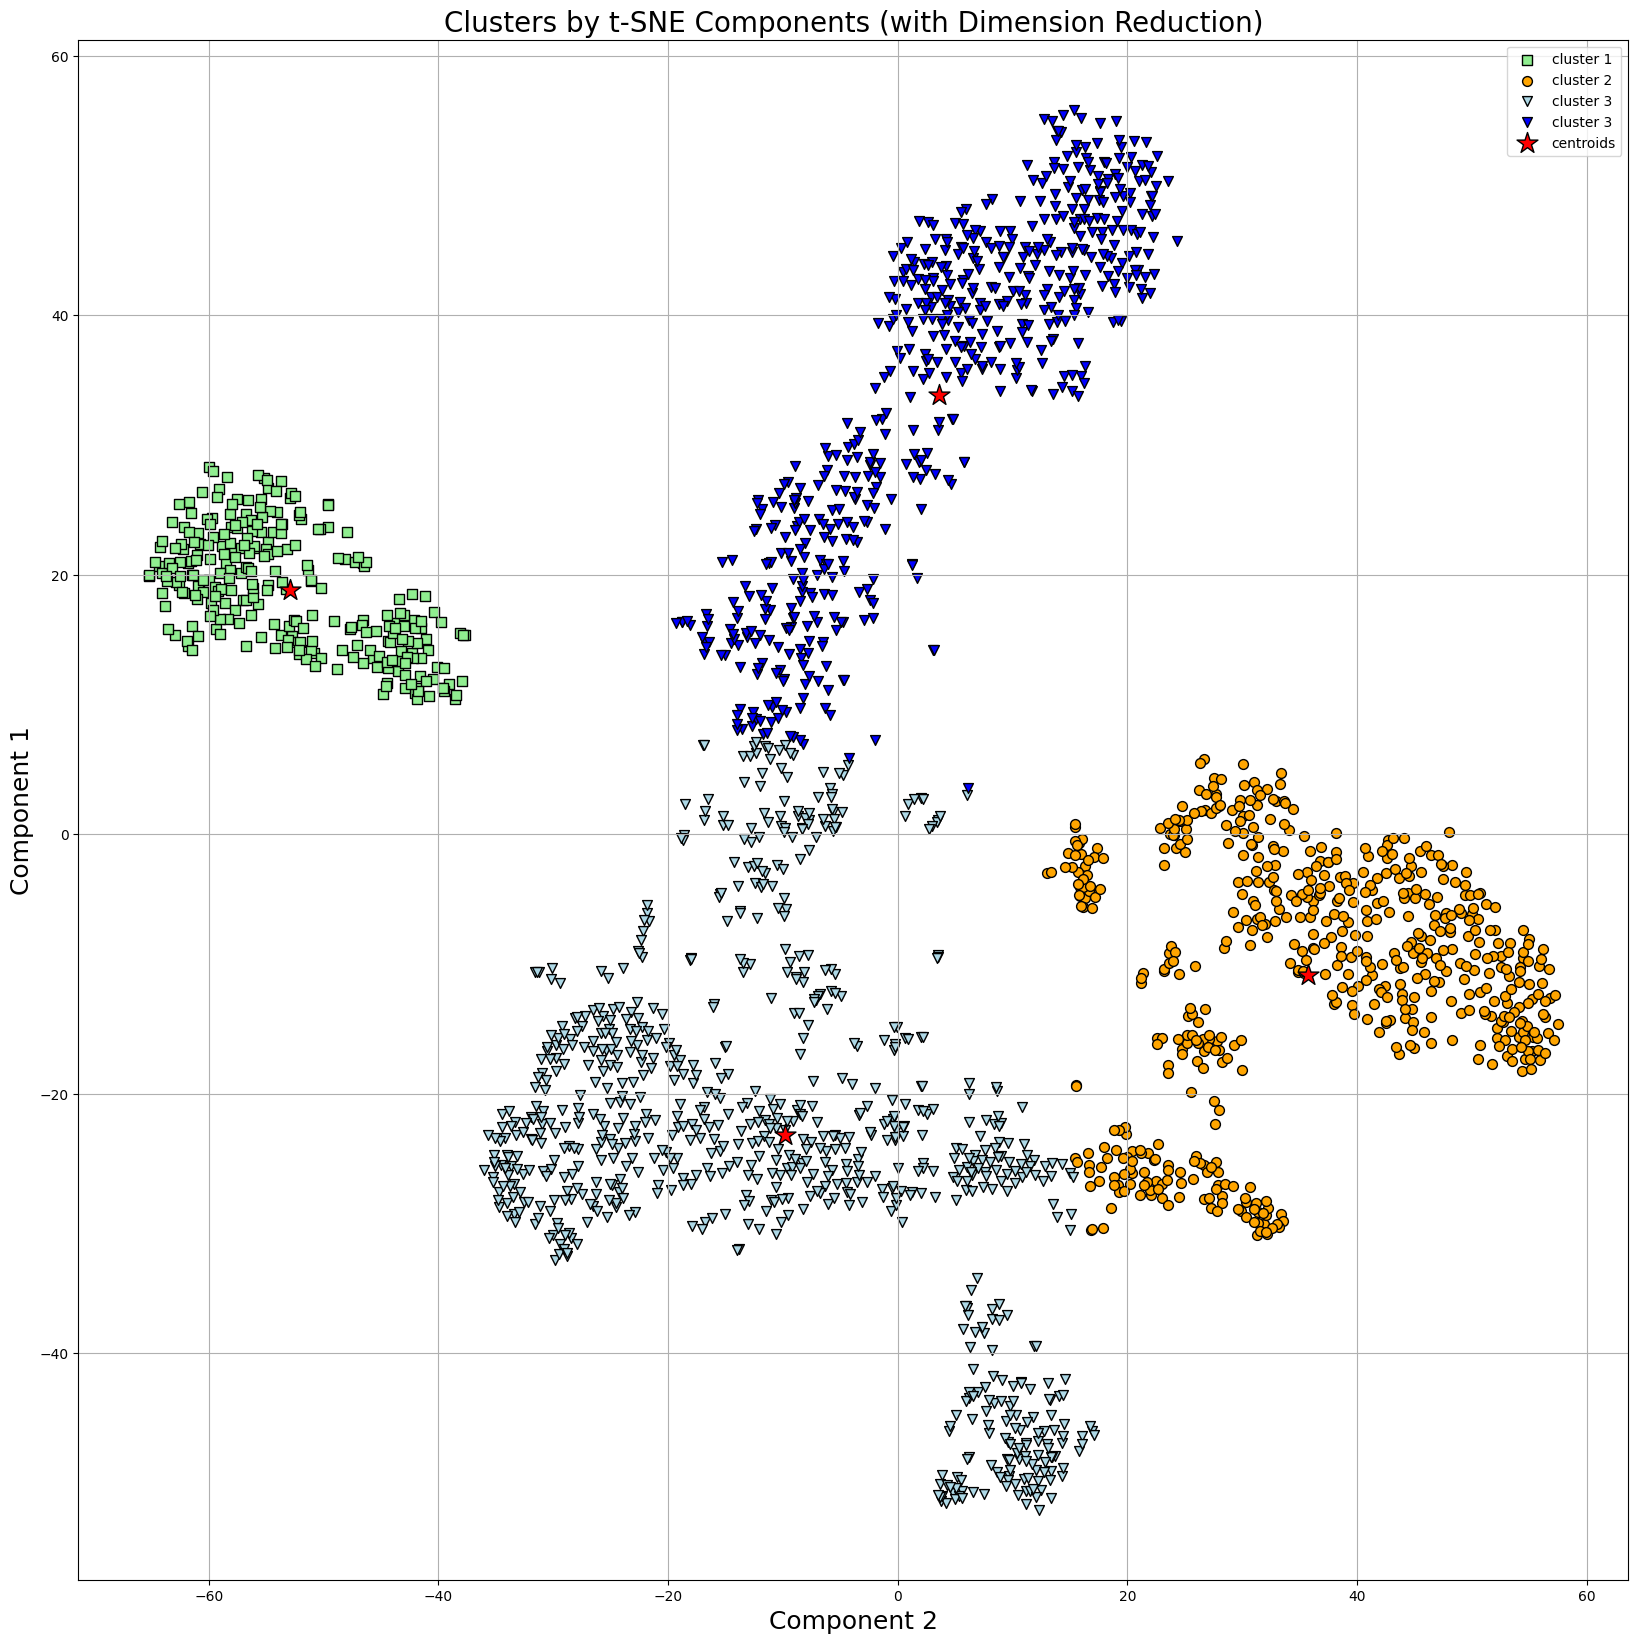

In [59]:
# plot the 3 clusters
plt.figure(figsize=(20, 20))
plt.scatter(
    model[y_km == 0, 0], model[y_km == 0, 1],
    s=50, c='lightgreen',
    marker='s', edgecolor='black',
    label='cluster 1'
)

plt.scatter(
    model[y_km == 1, 0], model[y_km == 1, 1],
    s=50, c='orange',
    marker='o', edgecolor='black',
    label='cluster 2'
)

plt.scatter(
    model[y_km == 2, 0], model[y_km == 2, 1],
    s=50, c='lightblue',
    marker='v', edgecolor='black',
    label='cluster 3'
)

plt.scatter(
    model[y_km == 3, 0], model[y_km == 3, 1],
    s=50, c='blue',
    marker='v', edgecolor='black',
    label='cluster 3'
)

# plot the centroids
plt.scatter(
    km.cluster_centers_[:, 0], km.cluster_centers_[:, 1],
    s=250, marker='*',
    c='red', edgecolor='black',
    label='centroids'
)
plt.legend(scatterpoints=1)
plt.title('Clusters by t-SNE Components (with Dimension Reduction)', fontsize=20)
plt.xlabel("Component 2", fontsize=18)
plt.ylabel("Component 1", fontsize=18)
plt.grid()
plt.show()

In [ ]:
kmeans_data_old = pd.read_csv('kmeans_results.csv')

#encoding class values
kmeans_data_old['class'] = kmeans_data_old['class'].str.replace('other', str(0))
kmeans_data_old['class'] = kmeans_data_old['class'].str.replace('biophony', str(1))
kmeans_data_old['class'] = kmeans_data_old['class'].str.replace('geophony', str(2))
kmeans_data_old['class'] = kmeans_data_old['class'].str.replace('anthrophony', str(3))

y_km = kmeans_data_old['class']
y_km.drop(y_km.tail(1).index, inplace=True)
y_km = y_km.values
y_km

In [61]:
%pip install seaborn

     ------------------------------------ 293.3/293.3 kB 476.5 kB/s eta 0:00:00
Note: you may need to restart the kernel to use updated packages.


[Text(0.5, 1.0, 'TSNE Plot with Ground Truth Overlayed'),
 Text(0, 0.5, 'TSNE Component 1'),
 Text(0.5, 0, 'TSNE Component 2')]

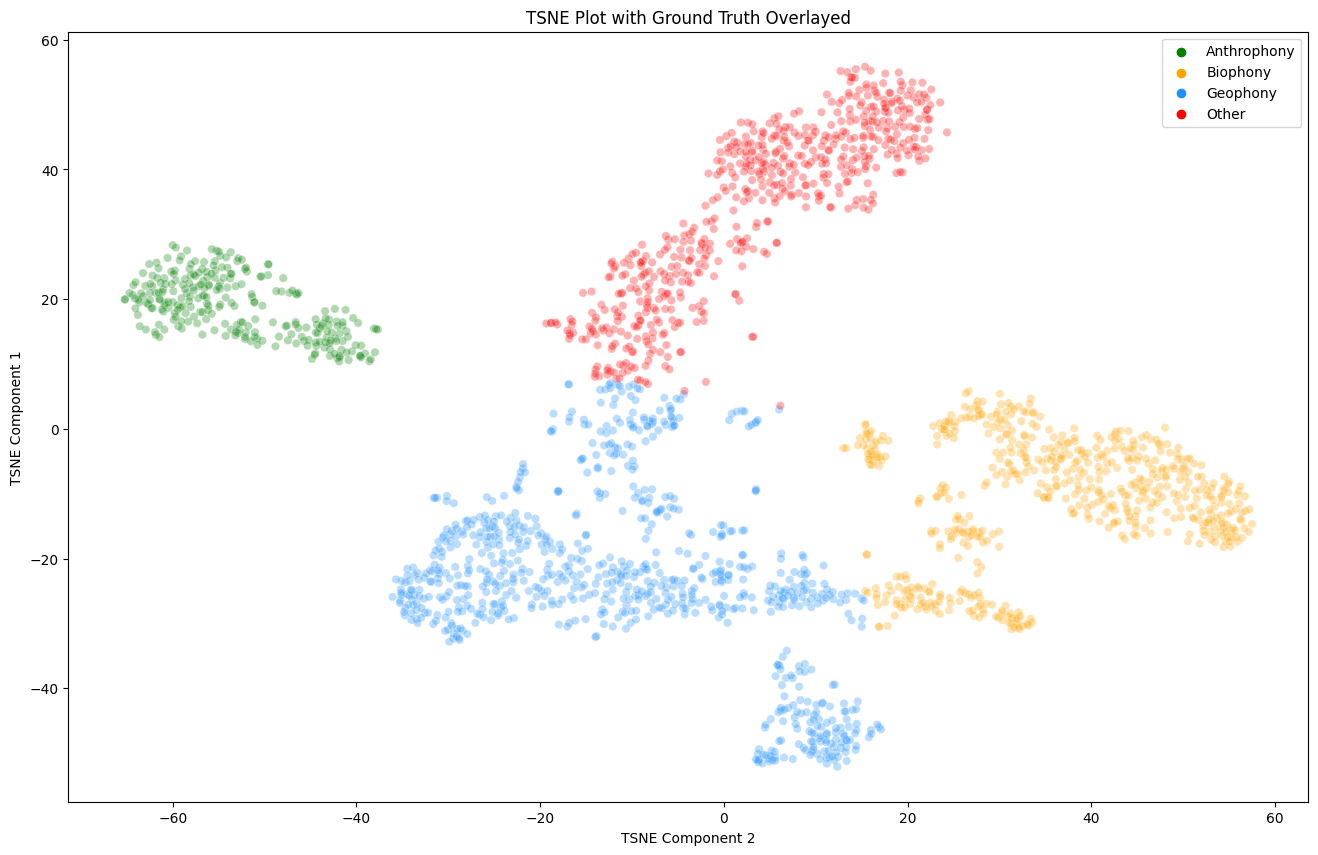

In [62]:
import seaborn as sns

x_axis=model[:,0]
y_axis=model[:,1]

plt.figure(figsize=(16,10))
ax=sns.scatterplot(
    x=x_axis, y=y_axis,
    hue=y_km,
    legend="full",
    alpha=0.3,
    palette=['green','orange','dodgerblue','red']
)
handles, labels = ax.get_legend_handles_labels()
ax.legend(handles, ['Anthrophony', 'Biophony', 'Geophony', 'Other'])
ax.set(title="TSNE Plot with Ground Truth Overlayed", ylabel="TSNE Component 1", xlabel="TSNE Component 2")

TODO: GET STATISTICS FOR ALL OF THE ABOVE GRAPHS
TODO: CREATE ADDITIONAL GRAPH (USING SAME TSNE RESULTS) WITHOUT DIMENSION REDUCTION

In [ ]:
kmeans_data_new = pd.read_csv('kmeans-nodr.csv', header='infer')
kmeans_data_new.drop(kmeans_data_new.tail(1).index,inplace=True) # drop last n rows

y_km = kmeans_data_new["Cluster"]

In [ ]:
import seaborn as sns

x_axis=model[:,0]
y_axis=model[:,1]

plt.figure(figsize=(16,10))
ax=sns.scatterplot(
    x=x_axis, y=y_axis,
    hue=y_km,
    legend="full",
    alpha=0.3,
    palette=['green','orange','dodgerblue','red']
)
handles, labels = ax.get_legend_handles_labels()
ax.legend(handles, ['Geophony', 'Anthrophony', 'Biophony', 'Other'])
ax.set(title="Kmeans Clustering Results without Dimension Reduction", ylabel="TSNE Component 1", xlabel="TSNE Component 2")

In [ ]:
kmeans_data_old = pd.read_csv('kmeans_results.csv', header='infer')

kmeans_data_old.drop(kmeans_data_old.tail(1).index,inplace=True) # drop last n rows
y_km = kmeans_data_old["kmeans_class"]



In [ ]:
import seaborn as sns

x_axis=model[:,0]
y_axis=model[:,1]

plt.figure(figsize=(16,10))
ax=sns.scatterplot(
    x=x_axis, y=y_axis,
    hue=y_km,
    legend="full",
    alpha=0.3,
    palette=['green','orange','dodgerblue','red']
)
handles, labels = ax.get_legend_handles_labels()
ax.legend(handles, ['Anthrophony', 'Other', 'Biophony', 'Geophony'])
ax.set(title="Kmeans Clustering Results with Dimension Reduction", ylabel="TSNE Component 1", xlabel="TSNE Component 2")

You will however be able to calculate statistics like within group variance and between group variance. The goal is to have low within group variance and high between group variance

In [ ]:
print(labels)

TODO: append results to k-means and use metrics to evaluate results against ground truth data

In [ ]:
df = pd.read_csv('kmeans.csv')
print(df)


In [ ]:
kmeans_df = pd.DataFrame(labels, columns=["kmeans_class"])

df = pd.concat([df, kmeans_df], axis=1)
print(df)
df.to_csv("kmeans_results.csv", index=False)

Rand Index - similarity of the two clustering assignments
Biophony = 0
Other = 1
Anthrophony = 2
Geophony = 3

In [ ]:
#kmeans_df['kmeans_class'].value_counts()

In [ ]:
from sklearn import metrics
kmeans_data = pd.read_csv('kmeans_results.csv', header='infer')

labels_pred = kmeans_data['kmeans_class']


#encoding class values
kmeans_data['class'] = kmeans_data['class'].str.replace('other', str(1))
kmeans_data['class'] = kmeans_data['class'].str.replace('biophony', str(0))
kmeans_data['class'] = kmeans_data['class'].str.replace('geophony', str(3))
kmeans_data['class'] = kmeans_data['class'].str.replace('anthrophony', str(2))

#print(kmeans_data)

labels_true = kmeans_data['class']

In [ ]:
metrics.rand_score(labels_true, labels_pred)

The Rand index does not ensure to obtain a value close to 0.0 for a random labelling. The adjusted Rand index corrects for chance and will give such a baseline.

In [ ]:
metrics.adjusted_rand_score(labels_true, labels_pred)

Mutual Information is a function that measures the agreement of the two assignments, ignoring permutations. Two different normalized versions of this measure are available, Normalized Mutual Information (NMI) and Adjusted Mutual Information (AMI). NMI is often used in the literature, while AMI was proposed more recently and is normalized against chance:

In [ ]:
metrics.adjusted_mutual_info_score(labels_true, labels_pred)

homogeneity: each cluster contains only members of a single class.

completeness: all members of a given class are assigned to the same cluster.

In [ ]:
metrics.homogeneity_score(labels_true, labels_pred)

In [ ]:
metrics.completeness_score(labels_true, labels_pred)

Their harmonic mean called V-measure is computed by v_measure_score:

In [ ]:
metrics.v_measure_score(labels_true, labels_pred)

The Fowlkes-Mallows score FMI is defined as the geometric mean of the pairwise precision and recall. A high value indicates a good similarity between two clusters

In [ ]:
metrics.fowlkes_mallows_score(labels_true, labels_pred)